   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 37.6 MB/s eta 0:00:00
📂 Sube el archivo DXF que deseas procesar:


Saving iroman2.dxf to iroman2.dxf
✅ Archivo cargado: iroman2.dxf
✂️ CORTAR: 16
🚫 NO CORTAR: 0
Polígonos corte: 0
Líneas corte: 16
Polígonos NO corte: 0
Líneas NO corte: 0


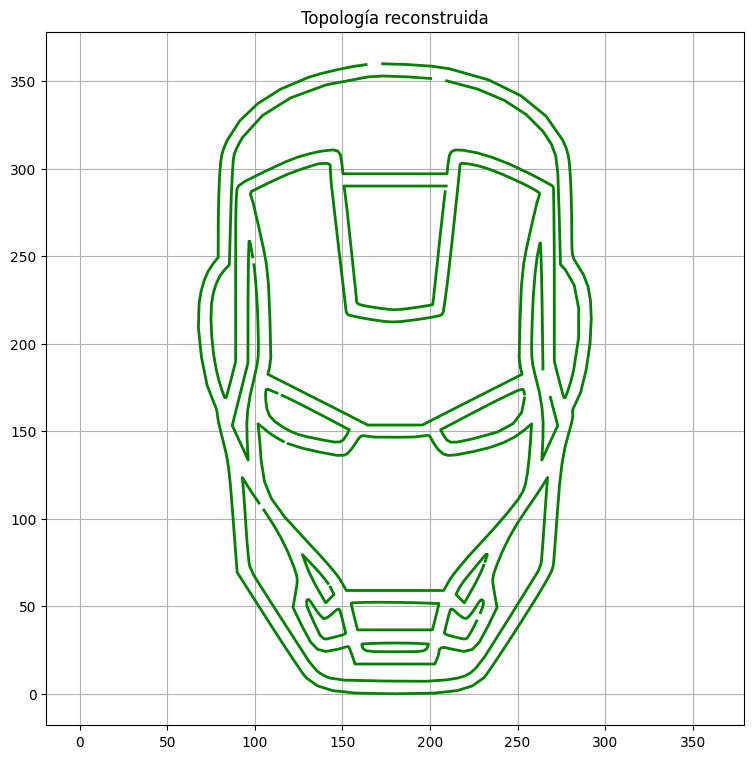

📄 Exportado: TrayectoriaScaraCnc_Ordenada.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📤 Archivo TXT listo para MATLAB / SCARA.


In [1]:
# =============================================================
# 🦾 CONVERSOR DXF → TXT SCARA-CNC (Topología + Color + Área)
# Harold & Abril · Versión unificada estable · 2025
# =============================================================

!pip install ezdxf shapely matplotlib numpy scipy scikit-learn --quiet

import ezdxf
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Polygon
from shapely.ops import linemerge, unary_union, polygonize
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
from google.colab import files
from itertools import chain

# =============================================================
# 1️⃣ SUBIR ARCHIVO DXF
# =============================================================
print("📂 Sube el archivo DXF que deseas procesar:")
uploaded = files.upload()
dxf_file = list(uploaded.keys())[0]
print(f"✅ Archivo cargado: {dxf_file}")

# =============================================================
# 2️⃣ LECTOR DXF (XY + color)
# =============================================================
doc = ezdxf.readfile(dxf_file)
msp = doc.modelspace()

geoms = []

def procesar_entidad(e):
    dtype = e.dxftype()
    color = e.dxf.color
    layer = e.dxf.layer

    try:
        if dtype == "LINE":
            start, end = e.dxf.start, e.dxf.end
            pts = [[start.x, start.y], [end.x, end.y]]

        elif dtype == "LWPOLYLINE":
            pts = np.array(e.get_points())[:, :2]

        elif dtype == "POLYLINE":
            pts = np.array([v.dxf.location[:2] for v in e.vertices])

        elif dtype == "CIRCLE":
            c, r = e.dxf.center, e.dxf.radius
            t = np.linspace(0, 2*np.pi, 200)
            pts = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "ARC":
            c, r = e.dxf.center, e.dxf.radius
            a1, a2 = np.deg2rad(e.dxf.start_angle), np.deg2rad(e.dxf.end_angle)
            if a2 < a1: a2 += 2*np.pi
            t = np.linspace(a1, a2, 120)
            pts = np.column_stack([c.x + r*np.cos(t), c.y + r*np.sin(t)])

        elif dtype == "SPLINE":
            fit = np.array(e.fit_points)
            if len(fit) >= 2:
                tck, _ = splprep([fit[:,0], fit[:,1]], s=0)
            else:
                ctrl = np.array(e.control_points)
                if len(ctrl) < 2: return
                tck, _ = splprep([ctrl[:,0], ctrl[:,1]], s=0)
            u = np.linspace(0, 1, 200)
            x, y = splev(u, tck)
            pts = np.column_stack([x, y])

        else:
            return

        geoms.append({"geom": LineString(pts), "color": color, "layer": layer})

    except:
        pass


for e in msp:
    procesar_entidad(e)

if not geoms:
    raise ValueError("⚠️ No se detectaron entidades válidas en el DXF.")

# =============================================================
# 3️⃣ CLASIFICAR POR COLOR
# =============================================================
def clasificar_color(color, layer):
    if color == 2 or "NO" in layer.upper():
        return "NO_CORTAR"
    return "CORTAR"

geoms_cortar   = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "CORTAR"]
geoms_nocortar = [g["geom"] for g in geoms if clasificar_color(g["color"], g["layer"]) == "NO_CORTAR"]

print(f"✂️ CORTAR: {len(geoms_cortar)}")
print(f"🚫 NO CORTAR: {len(geoms_nocortar)}")

# =============================================================
# 4️⃣ SNAP + MERGE + POLYGONIZE
# =============================================================
def merge_and_snap(geoms, tol=0.05):

    if not geoms:
        return []

    endpoints = []
    for g in geoms:
        c = list(g.coords)
        endpoints.append(c[0])
        endpoints.append(c[-1])

    endpoints = np.array(endpoints)
    labels = DBSCAN(eps=tol, min_samples=1).fit_predict(endpoints)
    n_clusters = labels.max() + 1

    centroids = np.zeros((n_clusters, 2))
    for k in range(n_clusters):
        centroids[k] = endpoints[labels == k].mean(axis=0)

    snapped = []
    for i, g in enumerate(geoms):
        coords = list(g.coords)
        coords[0]  = tuple(centroids[labels[2*i]])
        coords[-1] = tuple(centroids[labels[2*i+1]])
        snapped.append(LineString(coords))

    merged = linemerge(unary_union(snapped))
    if isinstance(merged, LineString): return [merged]
    if isinstance(merged, MultiLineString): return list(merged.geoms)
    return []


def process_category(geoms):

    merged = merge_and_snap(geoms)

    polys = list(polygonize(merged))
    opens = []

    if merged:
        diff = unary_union(merged).difference(unary_union(polys))

        if isinstance(diff, LineString):
            opens.append(diff)
        elif isinstance(diff, MultiLineString):
            opens.extend(list(diff.geoms))
        elif hasattr(diff, "geoms"):
            for g in diff.geoms:
                if isinstance(g, LineString): opens.append(g)
                elif isinstance(g, MultiLineString): opens.extend(g.geoms)

    uniq_polys = []
    seen = set()
    for p in polys:
        k = p.exterior.wkt
        if k not in seen:
            seen.add(k)
            uniq_polys.append(p)

    return uniq_polys, opens

# =============================================================
# 5️⃣ PROCESAR TOPOLOGÍA
# =============================================================
polys_cut,   opens_cut   = process_category(geoms_cortar)
polys_nocut, opens_nocut = process_category(geoms_nocortar)

print(f"Polígonos corte: {len(polys_cut)}")
print(f"Líneas corte: {len(opens_cut)}")
print(f"Polígonos NO corte: {len(polys_nocut)}")
print(f"Líneas NO corte: {len(opens_nocut)}")

# =============================================================
# 6️⃣ GRAFICAR
# =============================================================
plt.figure(figsize=(9,9))

for p in polys_cut:
    x,y = p.exterior.xy
    plt.fill(x,y,'g',alpha=0.3)
    plt.plot(x,y,'k-',lw=0.6)

for g in opens_cut:
    x,y = g.xy
    plt.plot(x,y,'g-',lw=2)

for p in polys_nocut:
    x,y = p.exterior.xy
    plt.fill(x,y,'y',alpha=0.3)
    plt.plot(x,y,'r--',lw=1)

for g in opens_nocut:
    x,y = g.xy
    plt.plot(x,y,'y--',lw=1)

plt.axis('equal')
plt.grid(True)
plt.title("Topología reconstruida")
plt.show()

# =============================================================
# 7️⃣ EXPORTAR TXT ORDENADO POR ÁREA
# =============================================================
def exportar_txt(nombre, polys_cut, opens_cut, polys_nocut, opens_nocut):

    polys_sorted = sorted(polys_cut, key=lambda p: abs(p.area))

    geoms_final = []
    for g in polys_sorted: geoms_final.append((g,1))
    for g in opens_cut:   geoms_final.append((g,1))
    for g in polys_nocut: geoms_final.append((g,0))
    for g in opens_nocut: geoms_final.append((g,0))

    with open(nombre, 'w') as f:
        f.write("X Y Z CORTAR\n")

        for i,(geom,flag) in enumerate(geoms_final):

            if isinstance(geom, Polygon):
                x,y = geom.exterior.xy
                x, y = x[:-1], y[:-1]
            else:
                x,y = geom.xy

            for xi, yi in zip(x,y):
                f.write(f"{xi:.6f} {yi:.6f} 0.000 {flag}\n")

            if i < len(geoms_final)-1:
                f.write("NaN NaN NaN NaN\n")

    print(f"📄 Exportado: {nombre}")
    files.download(nombre)


exportar_txt(
    "TrayectoriaScaraCnc_Ordenada.txt",
    polys_cut, opens_cut, polys_nocut, opens_nocut
)

print("📤 Archivo TXT listo para MATLAB / SCARA.")
